<a href="https://colab.research.google.com/github/Madhurima-Ghosh18/credit-card-fraud-detection/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SECTION: 1**

**STATEMENT : CREDIT CARD FRAUDULENT TRANSACTION PREDICTION**
*   Digital payments are evolving, but so are cyber criminals.
*   According to the Data Breach Index, more than 6 million records are being stolen on a daily basis, a concerning statistic that shows - fraud is still very common both for Card-Present and Card-not Present type of payments.
*   In today’s digital world where trillions of Card transaction happens per day, detection of fraud is challenging.
*   Hence our challenge is to detect the fraud transaction based on some pre-collected data
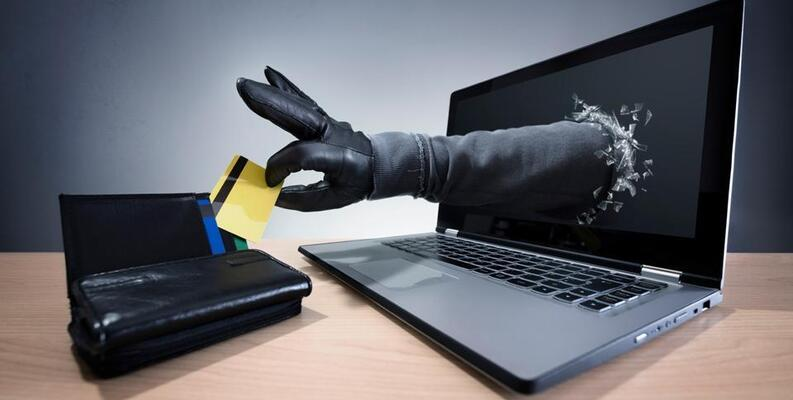

**Libraries**

In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (10, 6)})
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import shuffle
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant


**SECTION: 2**

THE DATASET IS TAKEN FROM:([https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud?resource=download](https://www.kaggle.com/datasets/dhanushnarayananr/credit-card-fraud?resource=download))

**About the data**

Features Explanation:

*   distance_from_home, numeric - the distance from home
where the transaction happened.
*   distance_from_last_transaction, numeric - the distance from last transaction happened.
*   ratio_to_median_purchase_price, numeric - Ratio of purchased price transaction to median purchase price.
*   repeat_retailer, binary - Is the transaction happened from same retailer.
*   used_chip, binary - Is the transaction through chip (credit card). (0 - chip not used , 1 - chip used)
*   used_pin_number, binary - Is the transaction happened by using PIN number. (0 -pin number not used , 1 - pin number used)
*   online_order, binary - Is the transaction an online order. ( 0 - online order not occured , 1 - online order ocuured)
*   fraud, binary - Is the transaction fraudulent. (0 - fraud happend, 1 - fraud not happend)

In [124]:
df = pd.read_csv("card_transdata.csv"); df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [125]:
df.shape

(1000000, 8)

In [126]:
#df.describe()

In [127]:
#df.info()

In [128]:
def plot_history(history,xlab = "",ylab1 = "", ylab2 = "", title1 = "",title2 = ""):
    fig = plt.figure(figsize = (13,6))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax.plot(history.history['loss'], label='loss train')
    ax.plot(history.history['val_loss'], label='loss val')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab1)
    ax.set_title(title1)
    ax.legend(loc='best')

    ax2.plot(history.history['binary_accuracy'], label='acc train')
    ax2.plot(history.history['val_binary_accuracy'], label='acc val')
    ax2.set_xlabel(xlab)
    ax2.set_ylabel(ylab2)
    ax2.set_title(title2)
    ax2.legend(loc = 'best')
    return

**SECTION: 3**

Data Preprocessing

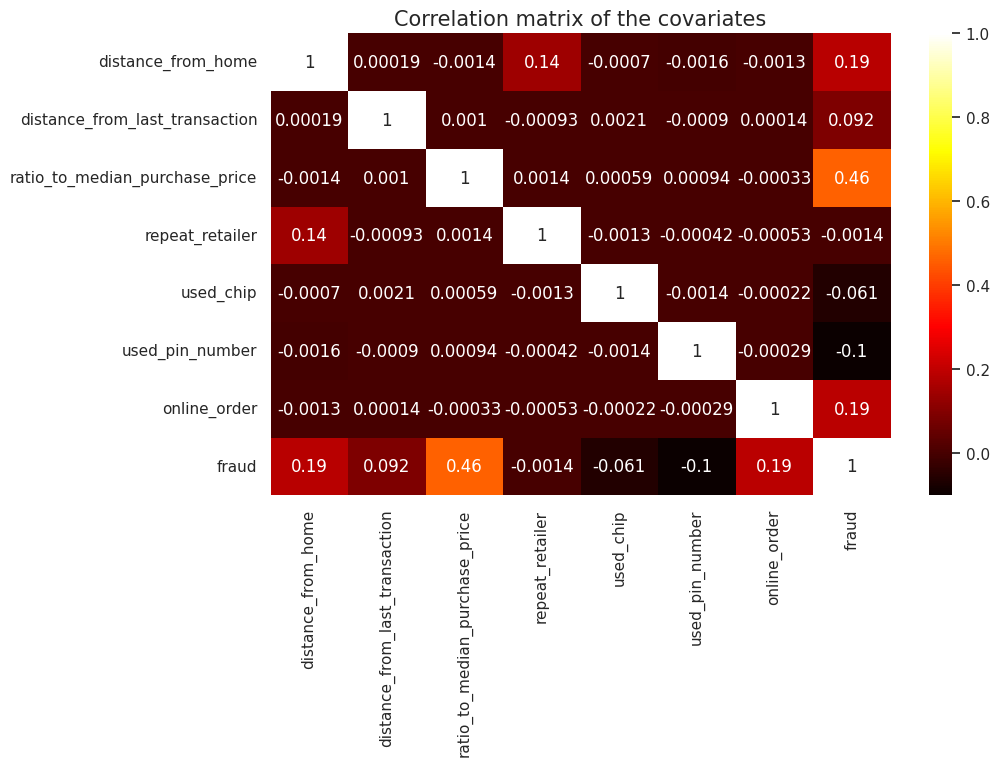

In [129]:
df_corr = df.corr()
sns.heatmap(df_corr, xticklabels = df_corr.columns, yticklabels = df_corr.columns, annot = True, cmap = "hot")
plt.title("Correlation matrix of the covariates", fontsize = 15)
plt.show()



*   From the above correlation matrix we can come up that all the covariates are independent to each other so we will consider all the covariates in our model

,count
Normal transaction,912597
Fraudulent transaction,87403


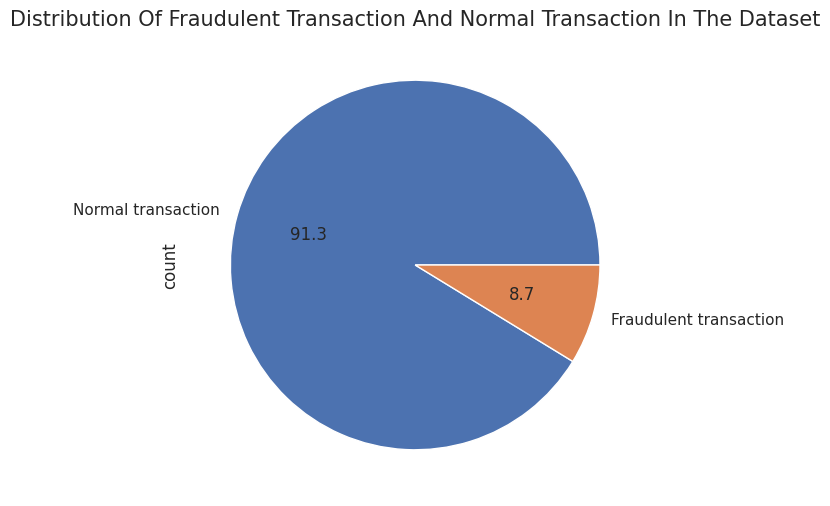

In [130]:
df1 = df.value_counts('fraud')
index_ = ["Normal transaction","Fraudulent transaction"]
df1.index = index_
df1.plot.pie(autopct = "%.1f")
plt.title('Distribution Of Fraudulent Transaction And Normal Transaction In The Dataset', fontsize = 15)
df1

Now the most of the data (91.3 %) comes from Normal Transaction and rest (8.7 %) comes from fraudulent transaction so we need to balance the both set of data classes so that we can come up with a better robust classifier

*   For that we need to Down-sample the data
*   Here we have taken the dataset randomly in such a way that 60% percent of the data comes from Normal Transaction and rest from Fraudulent transaction

**Down-Sampling of Data**

In [131]:
genuine = df[df["fraud"] == 0]
fraud = df[df["fraud"] == 1]

genuine_resample = genuine.sample(
    n=int(np.round(len(fraud) * (3 / 2))),
    random_state=42
)

In [132]:
data = pd.concat([genuine_resample, fraud],axis = 0)

In [133]:
data = shuffle(data); data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
790122,14.134287,0.022684,0.428453,1.0,0.0,0.0,0.0,0.0
429006,34.412216,103.251628,0.523003,1.0,0.0,0.0,1.0,1.0
222436,1.454966,1.458750,0.865813,0.0,1.0,0.0,1.0,0.0
815151,6.755614,1.232563,2.755453,1.0,0.0,0.0,1.0,0.0
4093,365.096997,11.962650,3.196129,1.0,1.0,0.0,1.0,0.0


In [134]:
print("Total data after downsampling - ",data.shape[0])

Total data after downsampling -  218507


,count
Normal transaction,131104
Fraudlent transaction,87403


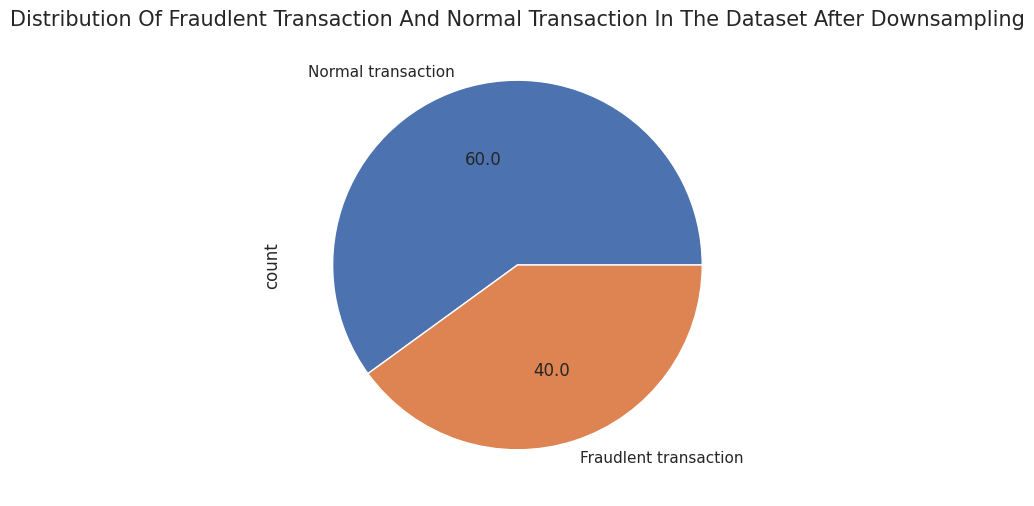

In [135]:
data1 = data.value_counts('fraud')
index_ = ["Normal transaction","Fraudlent transaction"]
data1.index = index_
data1.plot.pie(autopct = "%.1f")
plt.title('Distribution Of Fraudlent Transaction And Normal Transaction In The Dataset After Downsampling', fontsize = 15)
data1

**VIF**

In [136]:
label = data["fraud"]
feature = data.drop(["fraud"], axis = 1)

In [139]:
X= add_constant(feature)
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(feature.shape[1])], index= X.columns[0:-1])

In [140]:
vif

,0
const,12.055622
distance_from_home,1.034637
distance_from_last_transaction,1.002721
ratio_to_median_purchase_price,1.029459
repeat_retailer,1.025075
used_chip,1.008829
used_pin_number,1.010445


**SECTION: 4**

Train Test Split

In [141]:
feature.shape

(218507, 7)

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(feature, label, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(X_train,Y_train, test_size=0.2, random_state=42)

In [143]:
x_train1 = np.array(x_train).reshape(len(y_train),7,1)
x_val1 = np.array(x_val).reshape(len(y_val),7,1)
X_test1 = np.array(X_test).reshape(len(Y_test),7,1)

In [144]:
print('\033[1m'+"Training shape : ", x_train.shape)
print('\033[1m'+"Size of validation data : ", len(y_val))
print('\033[1m'+"Size of test data : ", len(Y_test))

Training shape :  (139844, 7)
Size of validation data :  34961
Size of test data :  43702




*   Now the basic model that is used to classify a binary class is a Linear Model ( Logistic Regression)

**LINEAR MODEL : LOGISTIC REGRESSION**

In [153]:
x_train2 = normalize(x_train)
x_test2 = normalize(X_test)
x_val2 = normalize(x_val)

In [154]:
clf_reg_lbfgs = LogisticRegression(solver = "newton-cg")
clf_reg_lbfgs.fit(x_train2, y_train)

LogisticRegression(solver='newton-cg')

In [155]:
print('\033[1m'+"Train Score using lbfgs : ", sum(clf_reg_lbfgs.predict(x_train2) == y_train)*100/len(X_train), "percentage")
print('\033[1m'+"Test Score using lbfgs  : ", sum(clf_reg_lbfgs.predict(x_test2) == Y_test)*100/len(X_test), "percentage")

Train Score using lbfgs :  63.58513772489345 percentage
Test Score using lbfgs  :  79.4792000366116 percentage


In [156]:
y_score1 = clf_reg_lbfgs.predict_proba(x_test2)[:,1]

In [157]:
false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(Y_test, y_score1)

In [158]:
print('\033[1m'+'roc_auc_score for Logistic Regression: ', roc_auc_score(Y_test, y_score1))

roc_auc_score for Logistic Regression:  0.9102549486234506


Hence Linear Model like logistic regression gives us accuracy of 79.47 percent in test data


*   So now we will try with non linear model for better testing accuracy

**NON LINEAR MODEL : DECISION TREE**

In [159]:
clf_tree = DecisionTreeClassifier(random_state=40, criterion="entropy")

In [164]:
clf_tree.fit(x_train, y_train)

y_predicted = clf_tree.predict(X_test.astype(int))
y_train_pred = clf_tree.predict(x_train)

print('\033[1m'+" Test accuracy of Decision tree is : ", accuracy_score(Y_test, y_predicted))
print('\033[1m'+" Train accuracy of Decision tree is : ", accuracy_score(y_train, y_train_pred))

 Test accuracy of Decision tree is :  0.9093405336140222
 Train accuracy of Decision tree is :  1.0


In [161]:
y_score2 = clf_tree.predict_proba(X_test.astype(int))[:,1]

In [162]:
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(Y_test, y_score2)

In [163]:
print('\033[1m'+'roc_auc_score for DecisionTree: ', roc_auc_score(Y_test, y_score2))

roc_auc_score for DecisionTree:  0.8870348567706664


The non linear model Decision Tree gives 90.93 percent accuracy in test data


*   So the non linear model decision tree gives better performance than linear model in terms of accuracy
*   But decision tree is very much biased on the train Data
*   So now we will build a random forest classifier model which is less biased on the training data

**Random Forest Classifier**

In [165]:
clf_rf = RandomForestClassifier(random_state = 10)
clf_rf.fit(x_train, y_train)
y_pred = clf_rf.predict(X_test.astype(int))
y_train_pred = clf_rf.predict(x_train.astype(int))

In [166]:
print('\033[1m'+"Test Accuracy of Random Forest is : ", accuracy_score(Y_test, y_pred))
print('\033[1m'+"Train Accuracy of Random Forest is : ", accuracy_score(y_train, y_train_pred))

Test Accuracy of Random Forest is :  0.9998398242643357
Train Accuracy of Random Forest is :  0.9998355310202798


In [167]:
y_score3 = clf_rf.predict_proba(X_test.astype(int))[:,1]

In [168]:
false_positive_rate3, true_positive_rate3, threshold3 = roc_curve(Y_test, y_score3)

In [169]:
print('\033[1m'+'roc_auc_score for Random Forest: ', roc_auc_score(Y_test, y_score3))

roc_auc_score for Random Forest:  0.9999999335240344


The non linear model Random Forest gives 99.98 percent accuracy in test data

**ROC Curve**

*  A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

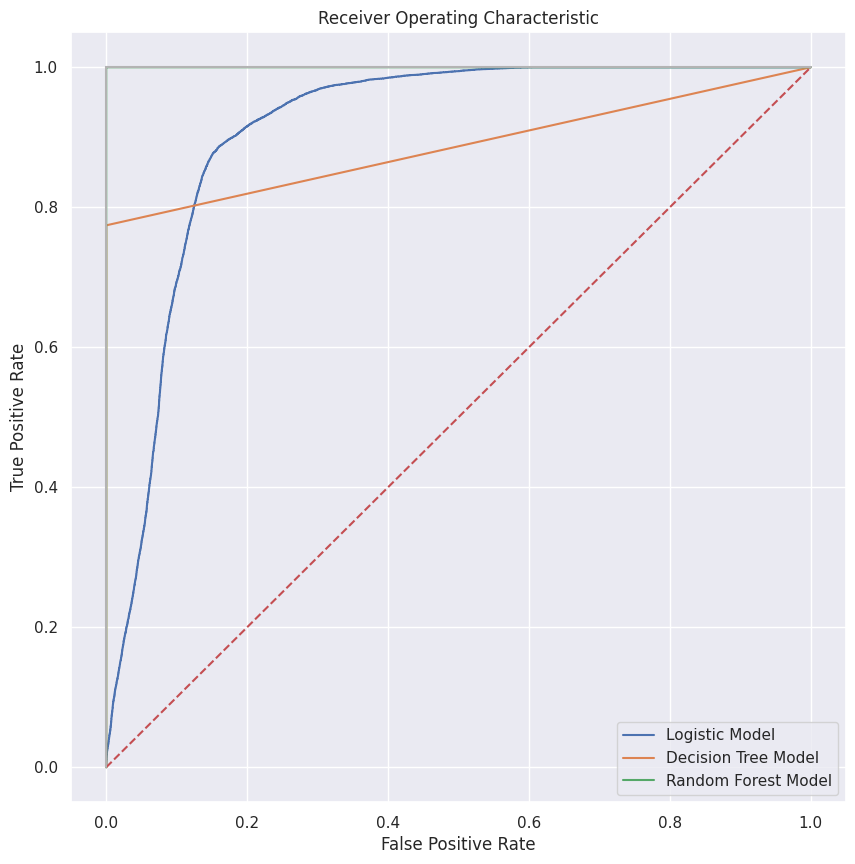

In [170]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate1, true_positive_rate1, label = "Logistic Model")
plt.plot(false_positive_rate2, true_positive_rate2, label = "Decision Tree Model")
plt.plot(false_positive_rate3, true_positive_rate3, label = "Random Forest Model")
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.legend(loc = "best")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

True positivity rate of Random Forest is highest among logistic regression

**So to classify fraud and non fraud transaction we have used**

*   Logistic regression (linear model) with test accuracy - 79.47 percent
*   Decision tree (non linear model) with test accuracy - 90.93 percent
*   Random Forest (non linear model) with test accuracy - 99.98 percent